In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [5]:
data = pd.read_csv('/kaggle/input/income/train.csv')
data.rename(columns={'income_>50K': 'income'}, inplace=True)
data.drop(columns=['fnlwgt'], axis=1, inplace=True)
data

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,67,Private,Doctorate,16,Divorced,Exec-managerial,Not-in-family,White,Male,99999,0,60,United-States,1
1,17,Private,12th,8,Never-married,Other-service,Own-child,White,Male,0,0,15,United-States,0
2,31,Private,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,40,United-States,1
3,58,State-gov,7th-8th,4,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,0
4,25,State-gov,Some-college,10,Never-married,Other-service,Not-in-family,Black,Male,0,0,40,United-States,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43952,52,Private,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,50,United-States,1
43953,19,Private,HS-grad,9,Never-married,Other-service,Own-child,White,Female,0,0,40,United-States,0
43954,30,Private,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,58,United-States,0
43955,46,Private,Bachelors,13,Never-married,Sales,Not-in-family,White,Female,0,0,35,United-States,0


In [13]:
# Define categorical and numerical features
TARGET = 'income'
CATEGORICAL_FEATURES = ['workclass', 'education', 'marital-status',
                        'occupation', 'relationship', 'race',
                        'gender', 'native-country']
NUMERIAL_FEATURES = [col for col in data.columns if col not in CATEGORICAL_FEATURES + [TARGET]]
NUM_CATEGORIES = [data[feature].nunique() for feature in CATEGORICAL_FEATURES]  # List comprehension to calculate num categories

data[CATEGORICAL_FEATURES] = data[CATEGORICAL_FEATURES].astype(str)
# Fill missing values in categorical features
data[CATEGORICAL_FEATURES] = data[CATEGORICAL_FEATURES].fillna('UNKNOWN')

## Label encode string features
### Not necessary if they are not strings

In [19]:
label_encoders = {}
for feature in CATEGORICAL_FEATURES:
    label_encoders[feature] = LabelEncoder()
    data[feature] = label_encoders[feature].fit_transform(data[feature])

In [20]:
NUM_CLASSES = data[TARGET].nunique()
HIDDEN_UNITS = [32, 32]  # Number of hidden units in each layer
DROPOUT_RATE = 0.2  # Dropout rate

In [15]:
def create_model_inputs():
    # Define input layers for categorical features
    cat_inputs = []
    for num_cat in NUM_CATEGORIES:
        cat_input = layers.Input(shape=(1,), dtype='int32')
        cat_inputs.append(cat_input)

    # Define input layer for numerical features
    num_input = layers.Input(shape=(len(NUMERIAL_FEATURES),))  # Corrected: use len(NUMERIAL_FEATURES)

    return cat_inputs, num_input

def encode_inputs(cat_inputs, num_input, use_embedding=False):
    # Encode categorical features
    encoded_cat_features = []
    for i, cat_input in enumerate(cat_inputs):
        if use_embedding:
            # Apply embedding layer
            embedding_dim = min(50, (NUM_CATEGORIES[i] + 1) // 2)  # Corrected: use NUM_CATEGORIES
            embedding = layers.Embedding(input_dim=NUM_CATEGORIES[i], output_dim=embedding_dim)(cat_input)  # Corrected: use NUM_CATEGORIES
            encoded_cat_feature = layers.Flatten()(embedding)
        else:
            # Apply one-hot encoding
            encoded_cat_feature = layers.Flatten()(layers.OneHot(NUM_CATEGORIES[i])(cat_input))  # Corrected: use NUM_CATEGORIES
        encoded_cat_features.append(encoded_cat_feature)

    # Normalize numerical features
    normalized_num_input = layers.BatchNormalization()(num_input)

    # Return encoded categorical and normalized numerical features
    return encoded_cat_features, normalized_num_input

In [16]:
def create_wide_and_deep_model():
    cat_inputs, num_input = create_model_inputs()

    # Encode inputs
    wide, deep = encode_inputs(cat_inputs, num_input, use_embedding=True)

    # Create deep network
    for units in HIDDEN_UNITS:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(DROPOUT_RATE)(deep)

    # Concatenate wide and deep parts
    merged = layers.concatenate([layers.concatenate(wide), deep])

    # Output layer
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)

    # Define model
    model = keras.Model(inputs=[*cat_inputs, num_input], outputs=outputs)
    return model

Epoch 1/10
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7904 - loss: 0.4202 - val_accuracy: 0.8504 - val_loss: 0.3260
Epoch 2/10
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8459 - loss: 0.3307 - val_accuracy: 0.8517 - val_loss: 0.3244
Epoch 3/10
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8463 - loss: 0.3274 - val_accuracy: 0.8518 - val_loss: 0.3218
Epoch 4/10
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8491 - loss: 0.3233 - val_accuracy: 0.8532 - val_loss: 0.3249
Epoch 5/10
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8499 - loss: 0.3226 - val_accuracy: 0.8508 - val_loss: 0.3248
Epoch 6/10
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8482 - loss: 0.3274 - val_accuracy: 0.8513 - val_loss: 0.3227
Epoch 7/10
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8455 - loss: 0.3276 - val_accuracy: 0.8511 - val_loss: 0.3248
Epoch 8/10
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8487 - loss: 0.3219 - 

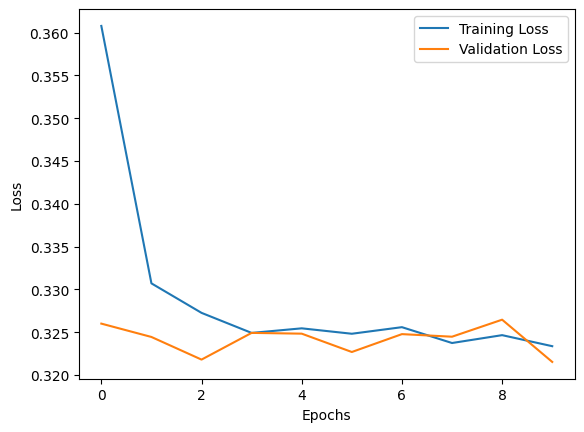

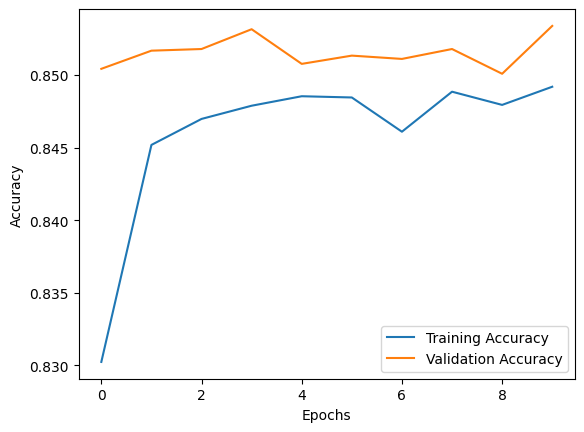

In [21]:
wide_and_deep_model = create_wide_and_deep_model()

# Compile the model
wide_and_deep_model.compile(optimizer='adam',
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

# Prepare input and output data
X_categorical = [data[feature].values for feature in CATEGORICAL_FEATURES]
X_numerical = data[NUMERIAL_FEATURES].values
y = pd.get_dummies(data[TARGET]).values  # One-hot encode the target variable

# Train the model
history = wide_and_deep_model.fit(X_categorical + [X_numerical], y, epochs=10, batch_size=32, validation_split=0.2)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Deep and cross model

In [32]:
def create_deep_and_cross_model():
    cat_inputs, num_input = create_model_inputs()

    # Encode inputs
    wide, deep = encode_inputs(cat_inputs, num_input, use_embedding=True)

    # Deep network
    for units in HIDDEN_UNITS:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(DROPOUT_RATE)(deep)

    # Cross network
    cross = wide[-1]  # Using wide features for cross network
    for _ in HIDDEN_UNITS:
        units = cross.shape[-1]  # Accessing output shape of the last layer
        x = layers.Dense(units)(cross)
        cross = wide[-1] * x + cross
    cross = layers.BatchNormalization()(cross)

    # Concatenate deep and cross parts
    merged = layers.concatenate([deep, cross])

    # Output layer
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)

    # Define model
    model = keras.Model(inputs=[*cat_inputs, num_input], outputs=outputs)
    return model



Epoch 1/10
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.7650 - loss: 0.4729 - val_accuracy: 0.8139 - val_loss: 0.4015
Epoch 2/10
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8063 - loss: 0.4189 - val_accuracy: 0.8107 - val_loss: 0.4039
Epoch 3/10
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8080 - loss: 0.4160 - val_accuracy: 0.8121 - val_loss: 0.4015
Epoch 4/10
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8107 - loss: 0.4088 - val_accuracy: 0.8104 - val_loss: 0.4022
Epoch 5/10
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8123 - loss: 0.4082 - val_accuracy: 0.8102 - val_loss: 0.4038
Epoch 6/10
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8107 - loss: 0.4127 - val_accuracy: 0.8097 - val_loss: 0.4024
Epoch 7/10
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8105 - loss: 0.4108 - val_accuracy: 0.8110 - val_loss: 0.4025
Epoch 8/10
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8126 - loss: 0.4052 - 

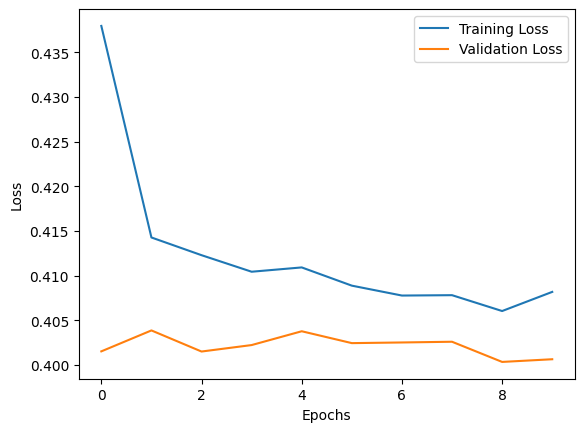

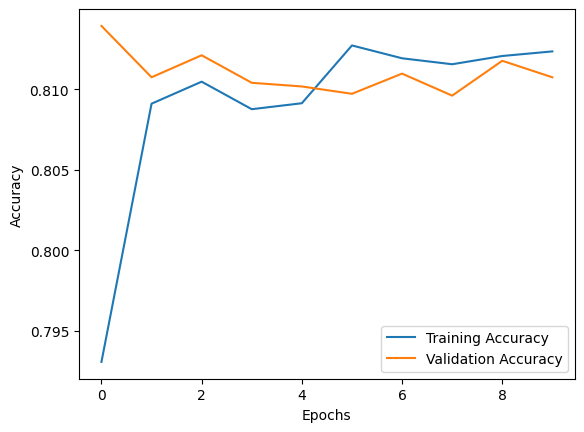

In [33]:
deep_and_cross_model = create_deep_and_cross_model()

# Compile the model
deep_and_cross_model.compile(optimizer='adam',
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])

# Train the model
history = deep_and_cross_model.fit(X_categorical + [X_numerical], y,
                                    epochs=10, batch_size=32, validation_split=0.2)

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Inference

In [ ]:
predictions = trained_model.predict([new_data_categorical] + [new_data_numerical])